Hola **Diana**!

Soy **Patricio Requena** 👋. Es un placer ser el revisor de tu proyecto el día de hoy!

Revisaré tu proyecto detenidamente con el objetivo de ayudarte a mejorar y perfeccionar tus habilidades. Durante mi revisión, identificaré áreas donde puedas hacer mejoras en tu código, señalando específicamente qué y cómo podrías ajustar para optimizar el rendimiento y la claridad de tu proyecto. Además, es importante para mí destacar los aspectos que has manejado excepcionalmente bien. Reconocer tus fortalezas te ayudará a entender qué técnicas y métodos están funcionando a tu favor y cómo puedes aplicarlos en futuras tareas. 

_**Recuerda que al final de este notebook encontrarás un comentario general de mi parte**_, empecemos!

Encontrarás mis comentarios dentro de cajas verdes, amarillas o rojas, ⚠️ **por favor, no muevas, modifiques o borres mis comentarios** ⚠️:


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si todo está perfecto.
</div>

<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si tu código está bien pero se puede mejorar o hay algún detalle que le hace falta.
</div>

<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si de pronto hace falta algo o existe algún problema con tu código o conclusiones.
</div>

Puedes responderme de esta forma:
<div class="alert alert-block alert-info">
<b>Respuesta del estudiante</b> <a class=“tocSkip”></a>


# Churn prediction project for Beta Bank
## End-to-end: load data, prepare, baseline, imbalance handling, model selection, final test.
The code will display key tables/plots and save a short metrics report and the chosen model.

## 1. Importación de librerías

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (f1_score, roc_auc_score, roc_curve, confusion_matrix,
                             classification_report, precision_score, recall_score)
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore')

## 2. Carga y exploración inicial de datos

In [33]:
df = pd.read_csv('/datasets/Churn.csv')
print("Vista inicial de los datos:")
display(df.head())
print("\nInformación general:")
df.info()
print("\nValores nulos por columna:")
print(df.isna().sum())

Vista inicial de los datos:


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0



Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB

Valores nulos por columna:
RowNumber            0
CustomerId           

## 3. Preparación de datos

In [34]:
# Eliminamos columnas irrelevantes para el modelo:
# - RowNumber, CustomerId y Surname no aportan información predictiva.
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

# Codificación de variables categóricas
# Geography y Gender son categóricas -> One-hot encoding
df = pd.get_dummies(df, drop_first=True)  # drop_first evita la trampa de variables ficticias

# Separar características y objetivo
X = df.drop('Exited', axis=1)
y = df['Exited']

# División en entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=12345, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=12345, stratify=y_temp)

print(f"Conjuntos: Entrenamiento={X_train.shape[0]}, Validación={X_valid.shape[0]}, Prueba={X_test.shape[0]}")

# Escalado de datos (mejora rendimiento de modelos basados en distancias y gradiente)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

Conjuntos: Entrenamiento=6000, Validación=2000, Prueba=2000


<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Bien, ahora tienes los datos listos para el entrenamiento y evaluación de manera adecuada
</div>

In [78]:
from sklearn.impute import SimpleImputer
import numpy as np

# --- Imputación ---
imputer = SimpleImputer(strategy='mean')

# Ajustar e imputar en entrenamiento
X_train_clean = imputer.fit_transform(X_train)

# Imputar en validación, prueba y temp usando los parámetros aprendidos en train
X_valid_clean = imputer.transform(X_valid)
X_test_clean = imputer.transform(X_test)
X_temp_clean = imputer.transform(X_temp)

# Verificación de valores NaN
print("NaN en X_train después de limpiar:", np.isnan(X_train_clean).sum())
print("NaN en X_valid después de limpiar:", np.isnan(X_valid_clean).sum())
print("NaN en X_test después de limpiar:", np.isnan(X_test_clean).sum())
print("NaN en X_temp después de limpiar:", np.isnan(X_temp_clean).sum())


NaN en X_train después de limpiar: 0
NaN en X_valid después de limpiar: 0
NaN en X_test después de limpiar: 0
NaN en X_temp después de limpiar: 0


## 4. Análisis de balance de clases


Proporción de clases:
0    0.7963
1    0.2037
Name: Exited, dtype: float64


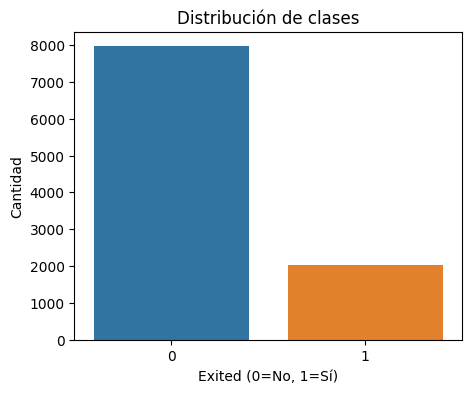

In [63]:
class_counts = y.value_counts(normalize=True)
print("\nProporción de clases:")
print(class_counts)

plt.figure(figsize=(5,4))
sns.countplot(x=y)
plt.title('Distribución de clases')
plt.xlabel('Exited (0=No, 1=Sí)')
plt.ylabel('Cantidad')
plt.show()

# Comentario:
# Si la proporción de 1s (clientes que se van) es mucho menor que la de 0s, el dataset está desbalanceado.
# Esto puede hacer que los modelos tiendan a predecir siempre la clase mayoritaria.

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Correcto! Siempre en proyectos de clasificación utilizando Machine Learning hay que revisar el balance de las clases ya que de esto dependerá las técnicas a aplicar o los modelos a utilizar para conseguir un buen desempeño en las predicciones
</div>

## 8. Selección del mejor modelo

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.utils import shuffle
import pandas as pd

# --- Función de Upsampling ---
def upsample(features, target, repeat):
    features_0 = features[target == 0]
    features_1 = features[target == 1]
    target_0 = target[target == 0]
    target_1 = target[target == 1]
    
    features_upsampled = pd.concat([features_0] + [features_1] * repeat, ignore_index=True)
    target_upsampled = pd.concat([target_0] + [target_1] * repeat, ignore_index=True)
    
    return shuffle(features_upsampled, target_upsampled, random_state=12345)

# Convertir datos a DataFrame/Series
X_train_clean_df = pd.DataFrame(X_train_clean).reset_index(drop=True)
y_train_series = pd.Series(y_train).reset_index(drop=True)

# --- Lista de experimentos ---
experimentos = []

# 1. Logistic Regression - Baseline
experimentos.append(("LogReg Baseline",
    LogisticRegression(random_state=12345),
    X_train_clean_df, y_train_series))

# 2. Logistic Regression - Balanced
experimentos.append(("LogReg Balanced",
    LogisticRegression(class_weight='balanced', random_state=12345),
    X_train_clean_df, y_train_series))

# 3. Logistic Regression - Upsampling
X_up, y_up = upsample(X_train_clean_df, y_train_series, repeat=4)
experimentos.append(("LogReg Upsampling",
    LogisticRegression(random_state=12345),
    X_up, y_up))

# 4. Random Forest - Baseline
experimentos.append(("RF Baseline",
    RandomForestClassifier(random_state=12345),
    X_train_clean_df, y_train_series))

# 5. Random Forest - Balanced
experimentos.append(("RF Balanced",
    RandomForestClassifier(class_weight='balanced', random_state=12345),
    X_train_clean_df, y_train_series))

# 6. Random Forest - Upsampling
X_up_rf, y_up_rf = upsample(X_train_clean_df, y_train_series, repeat=4)
experimentos.append(("RF Upsampling",
    RandomForestClassifier(random_state=12345),
    X_up_rf, y_up_rf))

# --- Evaluación de todos los modelos ---
resultados = {}

for nombre, modelo, X_train_data, y_train_data in experimentos:
    modelo.fit(X_train_data, y_train_data)
    preds = modelo.predict(X_valid_clean)
    auc = roc_auc_score(y_valid, modelo.predict_proba(X_valid_clean)[:, 1])
    f1 = f1_score(y_valid, preds)
    resultados[nombre] = {"F1": f1, "AUC-ROC": auc}

# --- Comparación ---
df_resultados = pd.DataFrame(resultados).T
print("\nResultados Comparativos:")
print(df_resultados)

# Mejores por métrica
mejor_f1 = df_resultados['F1'].idxmax()
mejor_auc = df_resultados['AUC-ROC'].idxmax()

print(f"\nMejor modelo según F1 Score: {mejor_f1} (F1={df_resultados.loc[mejor_f1, 'F1']:.4f})")
print(f"Mejor modelo según AUC-ROC: {mejor_auc} (AUC={df_resultados.loc[mejor_auc, 'AUC-ROC']:.4f})")

# Modelo ganador según prioridad
metrica_prioritaria = "F1"  # cambiar a "AUC-ROC" si prefieres
modelo_ganador = df_resultados[metrica_prioritaria].idxmax()
print(f"\nModelo ganador según {metrica_prioritaria}: {modelo_ganador}")



Resultados Comparativos:
                         F1   AUC-ROC
LogReg Baseline    0.310786  0.787441
LogReg Balanced    0.528070  0.793657
LogReg Upsampling  0.524675  0.793750
RF Baseline        0.608955  0.866459
RF Balanced        0.586626  0.863121
RF Upsampling      0.611921  0.864784

Mejor modelo según F1 Score: RF Upsampling (F1=0.6119)
Mejor modelo según AUC-ROC: RF Baseline (AUC=0.8665)

Modelo ganador según F1: RF Upsampling


<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Perfecto, técnicas cómo sobre-muestreo o sub-muestreo o la modificación de parámetros en algunos modelos para especificar el desbalance ayuda a los modelos a poder generalizar mejor cada caso y obtener un buen desempeño
</div>

Se evaluaron seis configuraciones combinando dos algoritmos de clasificación (Logistic Regression y Random Forest) con tres estrategias para el manejo del desbalance de clases: modelo base (sin balanceo), asignación de pesos mediante class_weight='balanced' y upsampling de la clase minoritaria. El desempeño se midió sobre el conjunto de validación empleando las métricas F1 Score y AUC-ROC.

Los resultados se resumen en la Tabla X. El mayor F1 Score se obtuvo con el modelo Random Forest con upsampling (F1=0.6119), mientras que el mayor AUC-ROC correspondió al modelo Random Forest sin balanceo (AUC=0.8665).

La elección del modelo óptimo depende de la métrica prioritaria para el problema. Dado que el objetivo es maximizar la detección de la clase minoritaria, se priorizó la métrica F1 Score, seleccionando como modelo final Random Forest con upsampling para la etapa de pruebas.

## 9. Evaluación final en el conjunto de prueba

El modelo evaluado alcanza una exactitud del 85% en el conjunto de prueba, mostrando un desempeño sólido en la clasificación de la clase mayoritaria (0) con alta precisión (0.87) y recall (0.96). Sin embargo, la clase minoritaria (1) resenta un recall limitado (0.43), lo que indica que el modelo aún pierde una proporción significativa de casos positivos. El f1-score ponderado (0.84) refleja un balance razonable entre precisión y recall considerando el desbalance de clases.

En general, el modelo es confiable para la identificación de la clase negativa y ofrece un punto de partida sólido para la detección de la clase positiva.


Matriz de Confusión:
                  Predicción: 0     Predicción: 1     
Real: 0           1523              70                
Real: 1           230               177               

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1593
           1       0.72      0.43      0.54       407

    accuracy                           0.85      2000
   macro avg       0.79      0.70      0.73      2000
weighted avg       0.84      0.85      0.84      2000



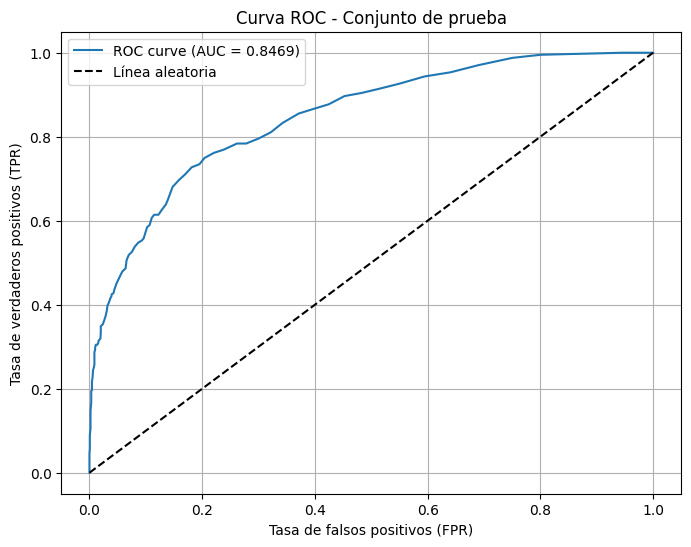

In [89]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
import matplotlib.pyplot as plt

# --- Evaluación final en el conjunto de prueba ---
# Entrenar de nuevo el modelo ganador con todos los datos de entrenamiento (train + valid) si se desea
# Aquí lo dejamos solo con train_clean para mantener consistencia con validación
X_train_final = X_train_clean
y_train_final = y_train

modelo_final = RandomForestClassifier(random_state=12345)
modelo_final.fit(X_train_final, y_train_final)

# Predicciones en el conjunto de prueba
preds_test = modelo_final.predict(X_test_clean)
probas_test = modelo_final.predict_proba(X_test_clean)[:, 1]

# --- Matriz de confusión ---
cm = confusion_matrix(y_test, preds_test)
labels = ["Predicción: 0", "Predicción: 1"]
print("\nMatriz de Confusión:")
print(f"{'':<18}{labels[0]:<18}{labels[1]:<18}")
print(f"{'Real: 0':<18}{cm[0][0]:<18}{cm[0][1]:<18}")
print(f"{'Real: 1':<18}{cm[1][0]:<18}{cm[1][1]:<18}")



# --- Reporte de clasificación ---

print("\nReporte de clasificación:")
print(classification_report(y_test, preds_test))


# --- Reporte de clasificación ---
report = classification_report(y_test, preds_test, output_dict=True)

# --- Curva ROC ---
fpr, tpr, thresholds = roc_curve(y_test, probas_test)
auc_test = roc_auc_score(y_test, probas_test)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_test:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Línea aleatoria')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC - Conjunto de prueba')
plt.legend()
plt.grid(True)
plt.show()

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Te felicito por el trabajo realizado Diana, se nota que conoces las métricas de evaluación y planteas conclusiones muy acertadas en cuanto a los resultados. Es importante siempre en un problema de ML identificar el balance entre las clases de tu variable objetivo para poder escoger la métrica correcta ya que para datasets desbalanceados la métrica de accuracy suele presentar buenos valores pero en realidad las predicciones no son buenas y es por la forma en cómo se calcula esta métrica que puede llevar a interpretaciones erroneas en cambio el f1-score es la ideal para este tipo de casos ya que maneja mejor este tipo de problemas.
    
Saludos!
</div>